In [1]:
using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV
using DataFrames

### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.821302,0.927363,0.711736,0.535813,1.0,4.0,1.0,2.0
2,0.82292,0.408885,0.327852,0.145537,2.0,3.0,1.0,5.0
3,0.903243,0.324958,0.472881,0.792971,2.0,3.0,2.0,5.0
4,0.248141,0.431387,0.452669,0.212659,2.0,3.0,2.0,2.0
5,0.105706,0.361876,0.615507,0.590829,2.0,1.0,1.0,1.0
6,0.247621,0.420247,0.377925,0.659608,1.0,3.0,2.0,4.0
7,0.66446,0.143438,0.84305,0.812453,3.0,1.0,2.0,2.0
8,0.683842,0.181385,0.137221,0.87001,2.0,4.0,1.0,2.0
9,0.420549,0.728429,0.513667,0.139647,2.0,1.0,2.0,3.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `SMOTE-NC` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,0.821302,0.927363,0.711736,0.535813,1.0,4.0,1.0,2.0
2,0.82292,0.408885,0.327852,0.145537,2.0,3.0,1.0,5.0
3,0.903243,0.324958,0.472881,0.792971,2.0,3.0,2.0,5.0
4,0.248141,0.431387,0.452669,0.212659,2.0,3.0,2.0,2.0
5,0.105706,0.361876,0.615507,0.590829,2.0,1.0,1.0,1.0
6,0.247621,0.420247,0.377925,0.659608,1.0,3.0,2.0,4.0
7,0.66446,0.143438,0.84305,0.812453,3.0,1.0,2.0,2.0
8,0.683842,0.181385,0.137221,0.87001,2.0,4.0,1.0,2.0
9,0.420549,0.728429,0.513667,0.139647,2.0,1.0,2.0,3.0


### 2. Apply SMOTE-NC

#### Using Imbalance Only

Applying SMOTE-NC using the standard API is very straightforward. There are two main hyperparameters which are the number of nearest neighbors `k` and the wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = smotenc(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:   9%|███▊                                     |  ETA: 0:00:06

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Progress:  22%|█████████▏                               |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02



Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
  class:  1


(168×8 DataFrame
 Row │ Column1   Column2   Column3   Column4    Column5  Column6  Column7  Col ⋯
     │ Float64   Float64   Float64   Float64    Cat…     Cat…     Cat…     Cat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.821302  0.927363  0.711736  0.535813   1.0      4.0      1.0      2.0 ⋯
   2 │ 0.82292   0.408885  0.327852  0.145537   2.0      3.0      1.0      5.0
   3 │ 0.903243  0.324958  0.472881  0.792971   2.0      3.0      2.0      5.0
   4 │ 0.248141  0.431387  0.452669  0.212659   2.0      3.0      2.0      2.0
   5 │ 0.105706  0.361876  0.615507  0.590829   2.0      1.0      1.0      1.0 ⋯
   6 │ 0.247621  0.420247  0.377925  0.659608   1.0      3.0      2.0      4.0
   7 │ 0.66446   0.143438  0.84305   0.812453   3.0      1.0      2.0      2.0
   8 │ 0.683842  0.181385  0.137221  0.87001    2.0      4.0      1.0      2.0
  ⋮  │    ⋮         ⋮         ⋮          ⋮         ⋮        ⋮        ⋮         ⋱
 162 │ 0.245498  0.4327

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
smotenc_model = SMOTENC(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)

(168×8 DataFrame
 Row │ Column1   Column2   Column3   Column4    Column5  Column6  Column7  Col ⋯
     │ Float64   Float64   Float64   Float64    Cat…     Cat…     Cat…     Cat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.821302  0.927363  0.711736  0.535813   1.0      4.0      1.0      2.0 ⋯
   2 │ 0.82292   0.408885  0.327852  0.145537   2.0      3.0      1.0      5.0
   3 │ 0.903243  0.324958  0.472881  0.792971   2.0      3.0      2.0      5.0
   4 │ 0.248141  0.431387  0.452669  0.212659   2.0      3.0      2.0      2.0
   5 │ 0.105706  0.361876  0.615507  0.590829   2.0      1.0      1.0      1.0 ⋯
   6 │ 0.247621  0.420247  0.377925  0.659608   1.0      3.0      2.0      4.0
   7 │ 0.66446   0.143438  0.84305   0.812453   3.0      1.0      2.0      2.0
   8 │ 0.683842  0.181385  0.137221  0.87001    2.0      4.0      1.0      2.0
  ⋮  │    ⋮         ⋮         ⋮          ⋮         ⋮        ⋮        ⋮         ⋱
 162 │ 0.245498  0.4327

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `smotenc` will take of encoding them and decoding them before and after applying the actual algorithm.

In [6]:
# For TableTransforms
Xy = CSV.read("dataset.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

Row,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,Body_Level
,Cat…,Float64,Float64,Float64,Cat…,Float64,Float64,Cat…,Cat…,Float64,Cat…,Cat…,Cat…,Float64,Float64,Cat…,Cat…
1,Female,22.5473,1.72246,51.8813,yes,2.66342,1.04111,no,no,3.0,Frequently,yes,no,0.794402,1.39195,Public_Transportation,Body Level 1
2,Male,19.7991,1.7437,54.9275,yes,2.0,2.84726,Sometimes,no,3.28926,Sometimes,yes,no,1.68084,2.0,Public_Transportation,Body Level 1
3,Female,17.8234,1.70841,50.0,yes,1.64224,1.09923,Sometimes,no,3.45259,Sometimes,no,no,0.418875,1.0,Public_Transportation,Body Level 1
4,Female,19.0072,1.69073,49.8957,yes,1.21291,1.0297,Sometimes,no,3.20707,Sometimes,no,no,2.0,1.0,Public_Transportation,Body Level 1
5,Male,19.7293,1.79331,58.1951,yes,2.50883,2.07693,no,no,3.4359,Sometimes,yes,no,2.02667,1.44333,Automobile,Body Level 1
6,Male,18.4706,1.85641,58.674,yes,2.34222,2.31179,no,no,3.9371,Sometimes,yes,no,2.01338,1.12835,Automobile,Body Level 1
7,Male,18.0,1.7387,50.2487,yes,1.87121,1.28374,Sometimes,no,3.0,Sometimes,yes,no,0.684879,1.48722,Public_Transportation,Body Level 1
8,Female,29.9704,1.61086,49.516,yes,2.05914,2.0,no,no,3.90486,Frequently,yes,no,0.821977,0.0,Public_Transportation,Body Level 1
9,Female,23.4443,1.59647,44.5946,no,2.59465,1.91681,no,no,1.88216,Frequently,no,no,0.417119,0.0,Public_Transportation,Body Level 1


Now we instantiate the model and simply pass the data to it using the pipeline operator `\>`. This is equivalent to calling `apply` from table transforms.

In [7]:
y_ind = 17
smote_model_t = SMOTENC_t(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Progress:   0%|▏                                        |  ETA: 0:01:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Progress:   5%|█▉                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Progress:  50%|████████████████████▌                    |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  class:  4.0


Row,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,Body_Level
,Cat…,Float64,Float64,Float64,Cat…,Float64,Float64,Cat…,Cat…,Float64,Cat…,Cat…,Cat…,Float64,Float64,Cat…,Cat…
1,Female,22.5473,1.72246,51.8813,yes,2.66342,1.04111,no,no,3.0,Frequently,yes,no,0.794402,1.39195,Public_Transportation,Body Level 1
2,Male,19.7991,1.7437,54.9275,yes,2.0,2.84726,Sometimes,no,3.28926,Sometimes,yes,no,1.68084,2.0,Public_Transportation,Body Level 1
3,Female,17.8234,1.70841,50.0,yes,1.64224,1.09923,Sometimes,no,3.45259,Sometimes,no,no,0.418875,1.0,Public_Transportation,Body Level 1
4,Female,19.0072,1.69073,49.8957,yes,1.21291,1.0297,Sometimes,no,3.20707,Sometimes,no,no,2.0,1.0,Public_Transportation,Body Level 1
5,Male,19.7293,1.79331,58.1951,yes,2.50883,2.07693,no,no,3.4359,Sometimes,yes,no,2.02667,1.44333,Automobile,Body Level 1
6,Male,18.4706,1.85641,58.674,yes,2.34222,2.31179,no,no,3.9371,Sometimes,yes,no,2.01338,1.12835,Automobile,Body Level 1
7,Male,18.0,1.7387,50.2487,yes,1.87121,1.28374,Sometimes,no,3.0,Sometimes,yes,no,0.684879,1.48722,Public_Transportation,Body Level 1
8,Female,29.9704,1.61086,49.516,yes,2.05914,2.0,no,no,3.90486,Frequently,yes,no,0.821977,0.0,Public_Transportation,Body Level 1
9,Female,23.4443,1.59647,44.5946,no,2.59465,1.91681,no,no,1.88216,Frequently,no,no,0.417119,0.0,Public_Transportation,Body Level 1


### 3. Plot the Results

We can finally plot the data before and after to validate the results.

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/Manifest.toml`


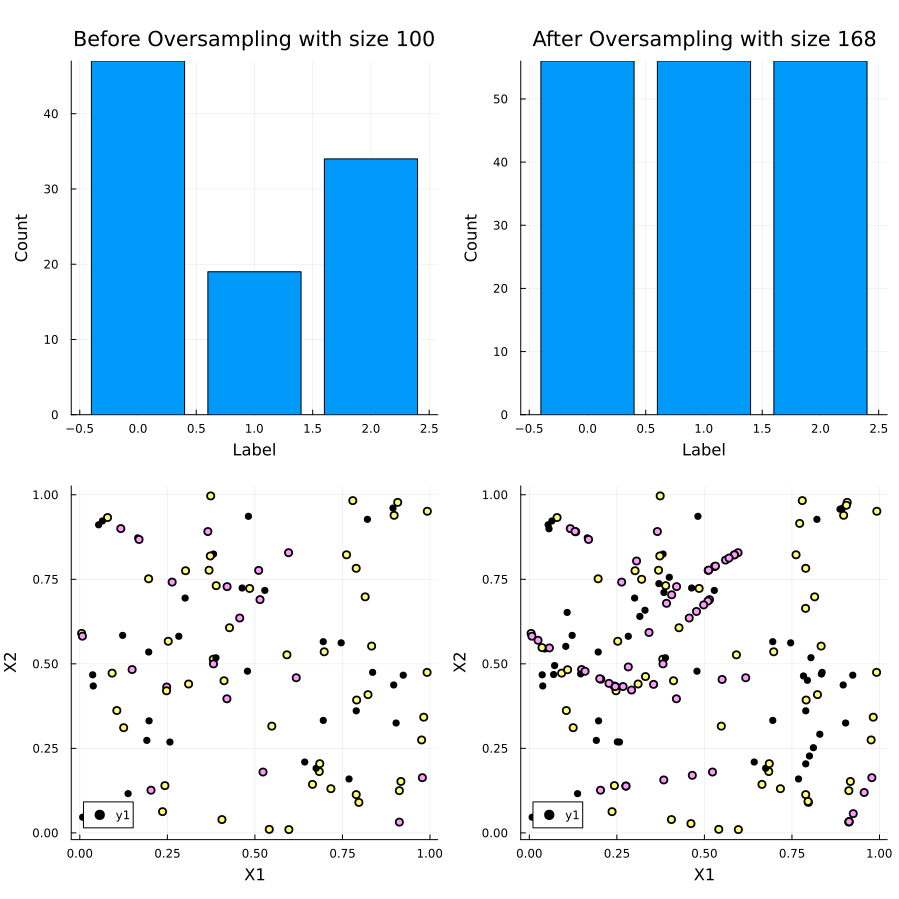

In [9]:
include("plot.jl")
plot_data(y, yover, X, Xover)